<a href="https://colab.research.google.com/github/shmorhunmsds/dx_703_final_project/blob/main/Milestone_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Project Milestone One: Forming Your Team, Understanding the Problem, and Exploring the Data

#### **Due:** Midnight on October 26th (with 2-hour grace period) — **worth 25 points**

> **Note:** Because we must begin manual grading immediately, there will be *no* late period for this milestone.

This milestone is the first phase of your project. You’ll begin working in teams, select your dataset, perform basic exploratory data analysis (EDA), and frame your classification problem.  

1. **Form your project team.**  
   Convene your team and complete the **Team Contract** (available in your Homework Repository). This is **due on Sunday, October 19th** at midnight (along with Homework 07). Each member must review and sign it before submission.

2. **Select a team leader.**  
   Choose one team member to act as the **Gradescope submitter** for your team. The entire team should collaborate on the notebook, but only the leader will submit.

3. **Explore your dataset and frame your task.**  
   You’ll work through the notebook to  
   - Examine both provided datasets,  
   - Choose one for your project,
   - Be able to describe the classification problem you’ll be solving in business or applied terms,
   - Conduct basic EDA to understand its structure and challenges, and
   - Spot potential challenges, propose solutions, and select appropriate performance metrics.  

This milestone focuses on understanding your data and clearly articulating what your model will eventually predict. You are not required to build a model yet (that will happen in Milestone 2) but of course you have lots of example models to choose from previous Homeworks and Coding Notebooks and you may wish to explore a baseline model as you do this first phase of your project.


### The Datasets

The final project is a **classification task** using **one of two datasets**—one image-based and one text-based. These are the two
domains we have studied in detail, after learning the fundamentals in the first three weeks, and you have all you need to approach either of these datasets with confidence.

#### **1. Food-101 (Images)**  
A web-scraped collection of approximately **101,000 color photos** across **101 food categories** (≈ 800 train / 100 validation / 100 test per class).  
Images vary widely in **lighting, composition, and color balance**, making this dataset excellent for practicing **data cleaning**, **EDA**, and **augmentation** techniques such as random crops, flips, and color jitter.

#### **2. HuffPost News Category (Text)**  
Roughly **200,000 short news items** labeled into **41 topical categories** (e.g., *POLITICS*, *ENTERTAINMENT*, *PARENTING*).  
Each record contains a **headline**, a **short description**, which we will concatenate with a separator token to make a single text string:
> `"headline [SEP] short_description"`.
>
The `[SEP]` token simply marks where the headline ends and the description begins—mirroring conventions used in transformer models such as BERT.


### What To Do


We’ve provided template code to start your project:

* **Download** your selected dataset.
* **Visualize** a few representative samples (images or text excerpts).

After reviewing both datasets, you’ll **choose one** for your semester project.

In the sections that follow:

* **Problem One — Exploratory Data Analysis (EDA):**
  Quantify scale and structure, check class balance, and note any missing/duplicate or inconsistent entries.

* **Problem Two — Challenges & Solution Paths:**
  Identify likely issues (e.g., overlapping categories, imbalanced labels, data-quality problems, length/size variance) and outline practical remedies you would try. *(No model training required.)*

For tips on working with **Hugging Face Datasets** (helpful for large datasets), see the **Appendix**.

> **Important:** Keep only the section for the dataset you select and delete the other before submitting **Milestone 1**.


In [ ]:
# ============================================
# Useful Imports
# ============================================

# --- Standard Libraries
import os
import time
import math
import random
from collections import Counter

# --- Core Data / Numerics
import numpy as np
import pandas as pd

# --- Visualization
import matplotlib.pyplot as plt
# import seaborn as sns              # optional
import matplotlib.ticker as mticker  # optional (for formatted axes)

# --- NLP / Tokenization
import spacy                         # used for text preprocessing (HuffPost)

# --- Progress Tracking
from tqdm import tqdm                # optional (nice for loops)

from IPython.display import display

# --- TensorFlow / Keras (Deep Learning)
import tensorflow as tf
from tensorflow.keras import layers, models, Input, callbacks, regularizers, initializers
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.optimizers.schedules import CosineDecay, ExponentialDecay
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import (
    Dense, Dropout, Flatten, MaxPooling2D, Conv2D,
    SeparableConv2D, GlobalAveragePooling2D, GlobalMaxPooling2D, BatchNormalization
)

# --- (Optional) Classical ML Baseline Tools
# from sklearn.pipeline import Pipeline
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score


# ============================================
# Global Configuration & Small Utilities
# ============================================

# Reproducibility
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
tf.keras.utils.set_random_seed(random_seed)   # sets Python, NumPy, and TensorFlow seeds

# Utility: format seconds as HH:MM:SS

"""
Example usage to time your code:

start_time = time.time()
# ... your code here ...
print("Execution Time:", format_hms(time.time() - start_time))
"""

def format_hms(seconds: float) -> str:
    """Convert seconds to HH:MM:SS format."""
    return time.strftime("%H:%M:%S", time.gmtime(seconds))


In [ ]:
# If needed (in a new env):
# !pip install -U datasets pillow

In [ ]:
# --- Hugging Face Datasets
from datasets import load_dataset, DatasetDict
from datasets.features import ClassLabel

## Prelude: Choose your dataset and take a first look

You’ll pick **one** dataset—either **Food-101 (images)** or **HuffPost (text)**—and run the starter cells to confirm it loads, view class stats, and skim a few samples.

* **Food-101 (images):** 101 classes of web photos with **inconsistent lighting, white balance, color casts, and composition** (plus varying resolutions). These natural quirks make augmentation and input-pipeline choices meaningful.
* **HuffPost (text):** ~200k headline/summary pairs across 41 topics with **class imbalance** and some **category overlap**—good for trying stratified splits and reporting macro-F1 in addition to accuracy.

After you review the two sections below (download → minimal EDA → split), **keep one and delete the other.** Stick with your choice for the entire project.

> **Note:** We use Hugging Face **Dataset/DatasetDict** objects (table-like datasets), not NumPy/Pandas arrays. Most of what you need to know is contained in the template code, but see the **Appendix** for more information on HG Datasets.


### Dataset One (Images): Food-101

#### **Load Food-101 as a Dataset**

> Note: this loads a **Hugging Face `Dataset`**, not NumPy or TensorFlow tensors.
> Each sample is stored as a **dictionary** with two keys — `"image"` (a PIL image object) and `"label"` (an integer class ID).
> You can access columns by name, e.g. `food_all["image"]` or `food_all["label"]`, and check the dataset size with `len(food_all)`.
> Unlike arrays, image sizes and aspect ratios may differ across samples — you’ll handle resizing or normalization later during preprocessing.


#### **Quick sanity checks (rows, label ids, a few image sizes)**

#### **Visual preview: random 3×3 grid from TRAIN**

---

In [ ]:
# JSON mirror that preserves fields: headline, short_description, category, authors, link, date
URL = "https://huggingface.co/datasets/khalidalt/HuffPost/resolve/main/News_Category_Dataset_v2.json"
huff_all = load_dataset("json", data_files=URL, split="train")

print(huff_all)
print("Columns:", huff_all.column_names)
print("Total rows:", len(huff_all))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


News_Category_Dataset_v2.json:   0%|          | 0.00/83.9M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['category', 'headline', 'authors', 'link', 'short_description', 'date'],
    num_rows: 200853
})
Columns: ['category', 'headline', 'authors', 'link', 'short_description', 'date']
Total rows: 200853


#### **Print 10 random samples (combined text with separator, no truncation)**

#### **(Optional) Save splits to disk (reload later without re-splitting)**

We provide this in case you want to save the dataset to your local disk. Saving Food-101 splits to disk is not recommended unless you have ample local storage (it's huge!).

In [ ]:
huff_all.save_to_disk("huffpost_splits")        # save
from datasets import load_from_disk
huff = load_from_disk("huffpost_splits")  # reload when needed

Saving the dataset (0/1 shards):   0%|          | 0/200853 [00:00<?, ? examples/s]

---

## Problem 1 – Choose the Dataset (10 pts) (Peter)

#### Objective
In this problem, you will explore the two provided datasets and select one to use for your final project.  
Your goal is to understand the structure, content, and challenges of the dataset through basic exploratory data analysis (EDA).  
By the end of this Milestone notebook, you should be able to explain what makes the dataset interesting, identify potential modeling challenges (e.g., imbalance, ambiguity, quality issues), and justify why it is a good choice for your classification project.


#### What to Do
1. **Load both datasets** and examine the outputs of the template code provided.  
   After this brief inspection, **choose one dataset for your project** and **delete the template code for the other.**  For your chosen dataset, continue with the remaining steps.

2. **Inspect** the dataset's basic properties:  
   - **Number of samples and classes:**  
     Determine how many total examples and distinct categories are present. Verify that the counts match expectations (e.g., 101 food classes or 41 news topics).  
   - **Example records or images:**  
     View several samples to understand the input format, diversity, and potential quality issues.  
     For images, note lighting or composition differences; for text, read a few headlines and summaries to see how expressive they are (done for you in template code).
   - **Distribution of labels (check for imbalance):**  
     Plot or tabulate label frequencies to see whether some classes dominate. Imbalanced datasets can bias model training and may require special handling.  
   - **Missing or inconsistent data:**  
     Look for empty fields, unreadable images, duplicate entries, or mislabeled samples. Handle or document any issues you find.  
   - **Overlapping or ambiguous class labels:**  
     Identify categories that may not be clearly distinct—e.g., “apple pie” vs. “cheesecake,” or “POLITICS” vs. “WORLD NEWS.”  
     Ambiguity in labels can increase confusion between classes and reduce model accuracy.

3. **Visualize key aspects:**  
   Extend the template code to complete the EDA for your chosen dataset:  
   - **Images:**  
     Create visual summaries to better understand the data (some are implemented in the template code).  
     - Verify that the dataset is balanced across classes.  
     - Display a small grid of random images to check variation in appearance, composition, and background (done in template code).  
     - Compare image sizes to determine whether resizing or normalization will be needed.  
     - Examine lighting and color balance—many web-scraped photos vary widely in brightness, saturation, and white balance.  
   - **Text:**  
     Visualize class balance and linguistic properties (some implemented in the template code).  
     - Plot the number of samples per label to confirm class balance or imbalance.  
     - Compute basic text statistics such as average word count or vocabulary size.  
     - Examine examples for duplicates, near-duplicates, or entries that might fit multiple categories.  
     - *(Optional)* Generate a word-frequency plot or word cloud to highlight distinctive terms for a few classes.

4. **Answer the graded questions below.**


In [ ]:
# Your code here, add as many cells as you like. Provide organization and structure by appropriate comments, labels, and variable names. Explain what you are doing in case you come back to this in a year.
# ============================================
# HuffPost Dataset Exploration and Analysis
# ============================================
print("loading huffpost dataset")
huff_all = load_from_disk("huffpost_splits")  # reload when needed

# basic dataset information
print("\n" + "-"*80)
print("Basic Datset Exploration")
print("-"*80 + "\n")
print(f"Total Samples: {len(huff_all):,}")
print(f"Columns: {huff_all.column_names}")
print(f"\nDataset features:")
print(huff_all.features)

# class distributions
print("\n" + "-"*80)
print("Class Distribution Analysis")
print("-"*80 + "\n")

# get all categories
categories = huff_all['category']
category_counts = Counter(categories)

print(f"\nTotal unique categories: {len(category_counts)}")
print(f"\nCategory distribution (sorted by frequency):")
print("-"* 80)

# convert to dataframe for easier analysis
category_df = pd.DataFrame.from_dict(category_counts, orient="index", columns=["count"])
category_df = category_df.sort_values(by="count", ascending=False)
print(category_df.to_string())

# calculate dataset imbalance
max_count = category_df['count'].max()
min_count = category_df['count'].min()
median_count = category_df['count'].median()
mean_count = category_df['count'].mean()

print(f"\nDataset Imbalance Metrics:")
print("-"*80)
print(f"Most Common Class: {category_df.index[0]} ({max_count:,} samples)")
print(f"Least common class: {category_df.index[-1]} ({min_count:,} samples)")
print(f"Median count: {median_count:.0f}")
print(f"Mean count: {mean_count:.0f}")
print(f"Imbalance Ratio (max/min): {max_count / min_count:.2f}")
print(f"Imbalance Ratio (max/median): {max_count / median_count:.2f}")

# identify minority classes (less than 1% of total)
threshold_1pct = len(huff_all) * 0.01
minority_classes = category_df[category_df['count'] < threshold_1pct]
print(f"\nMinority Classes (less than 1% of total samples):")
if len(minority_classes) > 0:
    print(minority_classes.to_string())
else:
    print("None")

# missing data analysis
print("\n" + "-"*80)
print("Missing Data Analysis")
print("-"*80)

# Check for missing or empty values
missing_stats = {}
for col in huff_all.column_names:
    data = huff_all[col]

    # Count None/null values
    none_count = sum(1 for x in data if x is None)

    # For string fields, count empty strings
    if col in ['headline', 'short_description', 'category', 'authors']:
        empty_count = sum(1 for x in data if x is not None and str(x).strip() == '')
        total_missing = none_count + empty_count
    else:
        total_missing = none_count

    missing_stats[col] = {
        'none_count': none_count,
        'empty_count': empty_count if col in ['headline', 'short_description', 'category', 'authors'] else 0,
        'total_missing': total_missing,
        'pct_missing': (total_missing / len(huff_all)) * 100
    }

missing_df = pd.DataFrame(missing_stats).T
print(missing_df.to_string())

# text length analysis
print("\n" + "-"*80)
print("Text Length Analysis")
print("-"*80 + "\n")

# create combined text field "headline [SEP] short_description"
print("\nCreating combined text field (headline [SEP] short_description)...")
combined_texts = []
headline_lengths = []
desc_lengths = []
combined_lengths = []
word_counts = []

for i in range(len(huff_all)):
    headline = (huff_all[i].get('headline') or '').strip()
    desc = (huff_all[i].get('short_description') or '').strip()
    combined = f"{headline} [SEP] {desc}".strip()

    headline_lengths.append(len(headline))
    desc_lengths.append(len(desc))
    combined_lengths.append(len(combined))
    word_counts.append(len(combined.split()))
    combined_texts.append(combined)

# calculate statistics
def print_length_stats(name, lengths):
    print(f"\n{name}:")
    print(f"  Min: {min(lengths)}")
    print(f"  Max: {max(lengths)}")
    print(f"  Mean: {np.mean(lengths):.2f}")
    print(f"  Median: {np.median(lengths):.2f}")
    print(f"  50th percentile: {np.percentile(lengths, 50):.2f}")
    print(f"  75th percentile: {np.percentile(lengths, 75):.2f}")
    print(f"  90th percentile: {np.percentile(lengths, 90):.2f}")
    print(f"  95th percentile: {np.percentile(lengths, 95):.2f}")
    print(f"  99th percentile: {np.percentile(lengths, 99):.2f}")

print_length_stats("Headline character lengths", headline_lengths)
print_length_stats("Description character lengths", desc_lengths)
print_length_stats("Combined text character lengths", combined_lengths)
print_length_stats("Combined text word counts", word_counts)

# Estimate truncation rates at different max_length values
print("\nTruncation Impact Analysis")
for max_len in [128, 256, 384, 512]:
    truncated = sum(1 for wc in word_counts if wc > max_len)
    pct = (truncated / len(word_counts)) * 100
    print(f"Max length {max_len} tokens: {truncated:,} samples ({pct:.2f}%) would be truncated") # looks like we're good at 128


# duplicate detection
print("\n" + "-"*80)
print("Duplicate Detection")
print("-"*80 + "\n")

# check for exact duplicates in combined text
unique_texts = set(combined_texts)
duplicate_count = len(combined_texts) - len(unique_texts)
print(f"\nExact duplicate texts: {duplicate_count} ({(duplicate_count / len(combined_texts)*100):.2f}%)")

# check for duplicate headlines
headlines = [huff_all[i].get('headline') or '' for i in range(len(huff_all))]
unique_headlines = set(headlines)
duplicate_headlines = len(headlines) - len(unique_headlines)
print(f"Duplicate headlines: {duplicate_headlines} ({(duplicate_headlines/len(headlines)*100):.2f}%)")

# vocabulary analysis
print("\n" + "-"*80)
print("Vocabulary Analysis")
print("-"*80 + "\n")

# build vocabulary from all texts
print("\nBuilding vocabulary from combined texts...")
all_words = []
for text in combined_texts:
    words = text.lower().split()
    all_words.extend(words)

word_freq = Counter(all_words)
print(f"\nTotal tokens: {len(all_words):,}")
print(f"Unique tokens (vocabulary size): {len(word_freq):,}")
print(f"Average tokens per document: {len(all_words)/len(combined_texts):.2f}")

# Most common words
print("\nTop 20 most common words:")
for word, count in word_freq.most_common(20):
    print(f"  {word}: {count:,}")

# save summary statistics to csvs
print("\n" + "-"*80)
print("Saving Results")
print("-"*80)

# Save category distribution
category_df.to_csv('category_distribution.csv')
print("Saved category distribution to 'category_distribution.csv'")

# Save missing data stats
missing_df.to_csv('missing_data_stats.csv')
print("Saved missing data stats to 'missing_data_stats.csv'")

# Save text length stats
length_stats_df = pd.DataFrame({
    'headline_char_length': headline_lengths,
    'description_char_length': desc_lengths,
    'combined_char_length': combined_lengths,
    'word_count': word_counts
})
length_stats_df.to_csv('text_length_stats.csv', index=False)
print("Saved text length statistics to 'text_length_stats.csv'")

loading huffpost dataset

--------------------------------------------------------------------------------
Basic Datset Exploration
--------------------------------------------------------------------------------

Total Samples: 200,853
Columns: ['category', 'headline', 'authors', 'link', 'short_description', 'date']

Dataset features:
{'category': Value('string'), 'headline': Value('string'), 'authors': Value('string'), 'link': Value('string'), 'short_description': Value('string'), 'date': Value('timestamp[s]')}

--------------------------------------------------------------------------------
Class Distribution Analysis
--------------------------------------------------------------------------------


Total unique categories: 41

Category distribution (sorted by frequency):
--------------------------------------------------------------------------------
                count
POLITICS        32739
WELLNESS        17827
ENTERTAINMENT   16058
TRAVEL           9887
STYLE & BEAUTY   9649
P

## Dataset Visualizations

Loading HuffPost dataset...

 creating class distribution visualization...
Saved: class_distribution.png


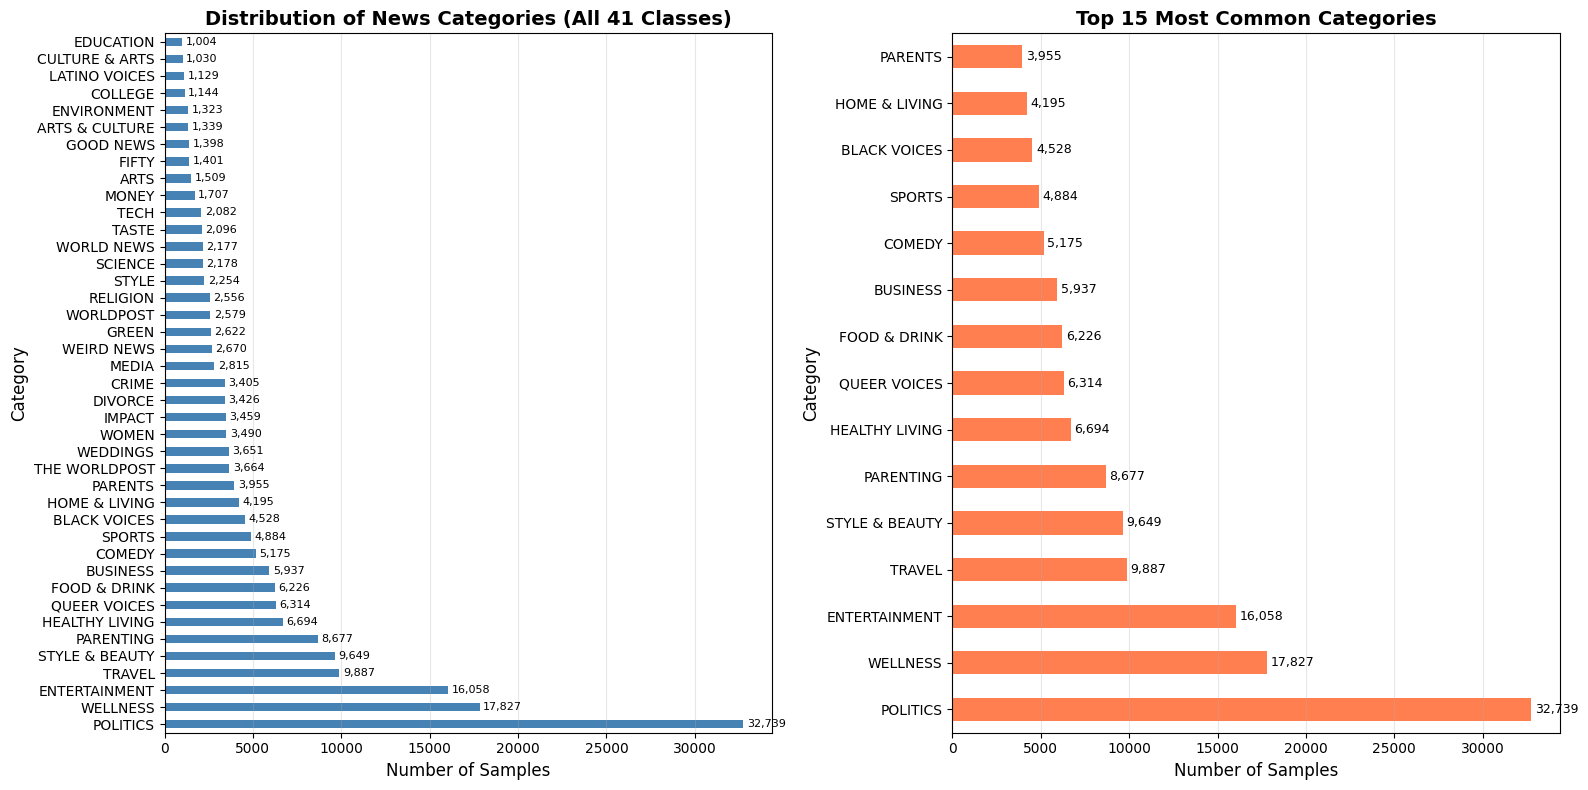

Creating class imbalance visualization...
Saved: class_imbalance.png


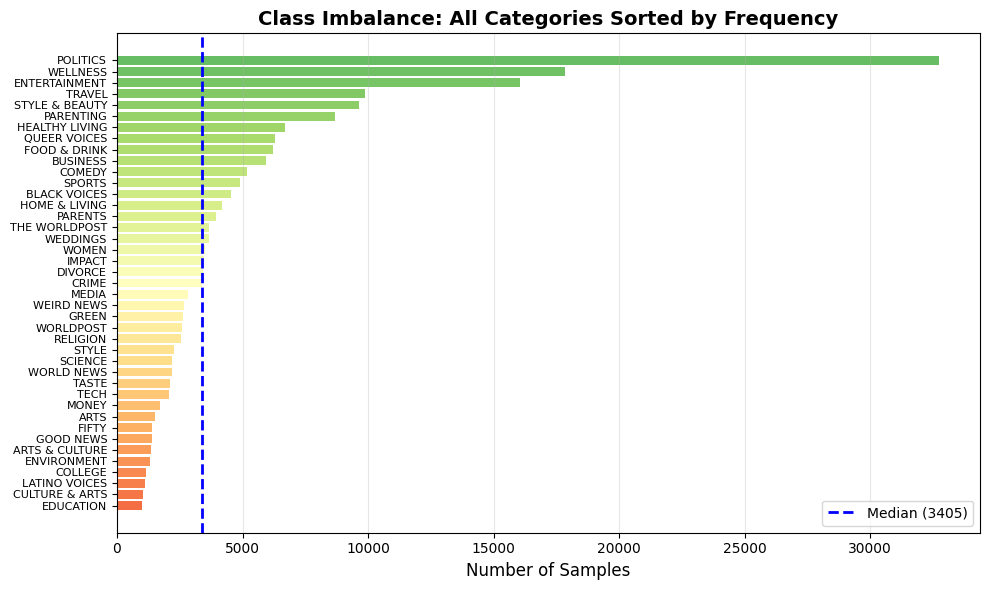

Creating text length distribution visualizations...
Saved: text_length_distributions.png


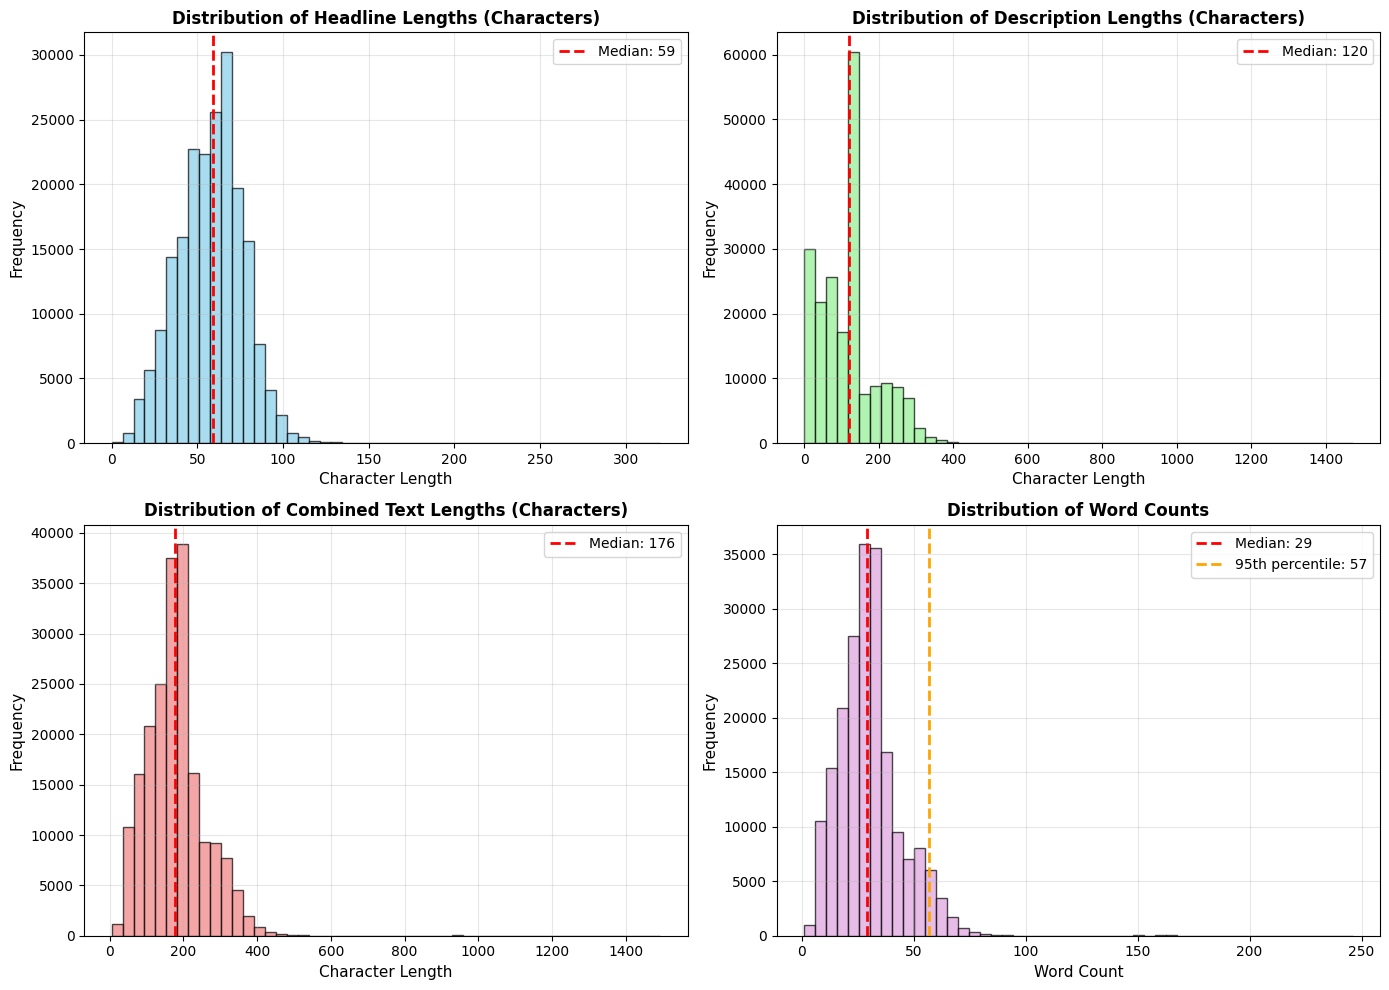

Creating text length box plots...


/tmp/ipython-input-505404330.py:142: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=['Headline\n(chars)', 'Description\n(chars)', 'Combined\n(chars)', 'Word Count\n(x5)'],


Saved: text_length_boxplots.png


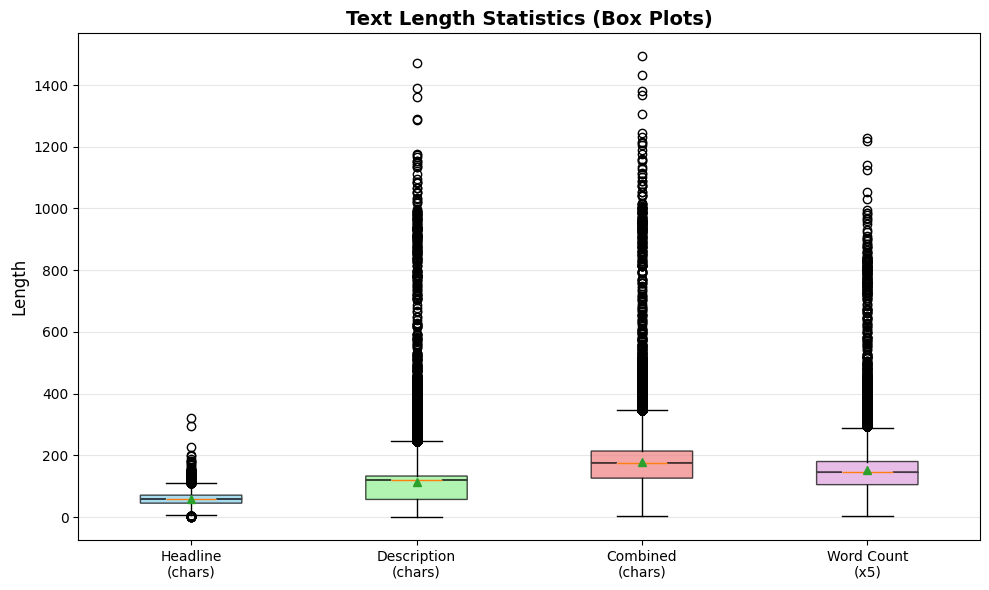

Creating missing data visualization...
Saved: missing_data.png


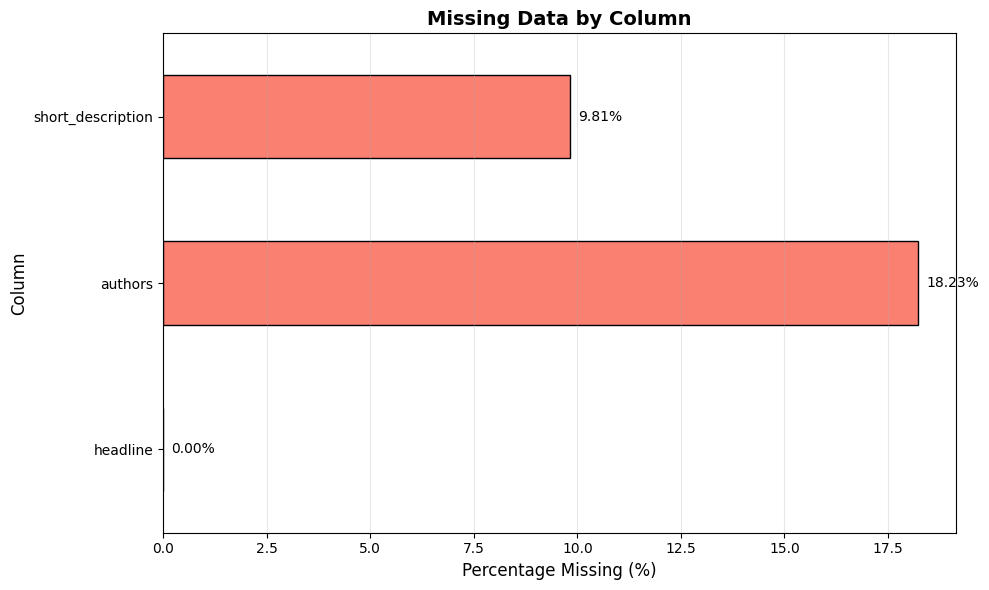

Creating category sample comparison...
Saved: category_comparison.png


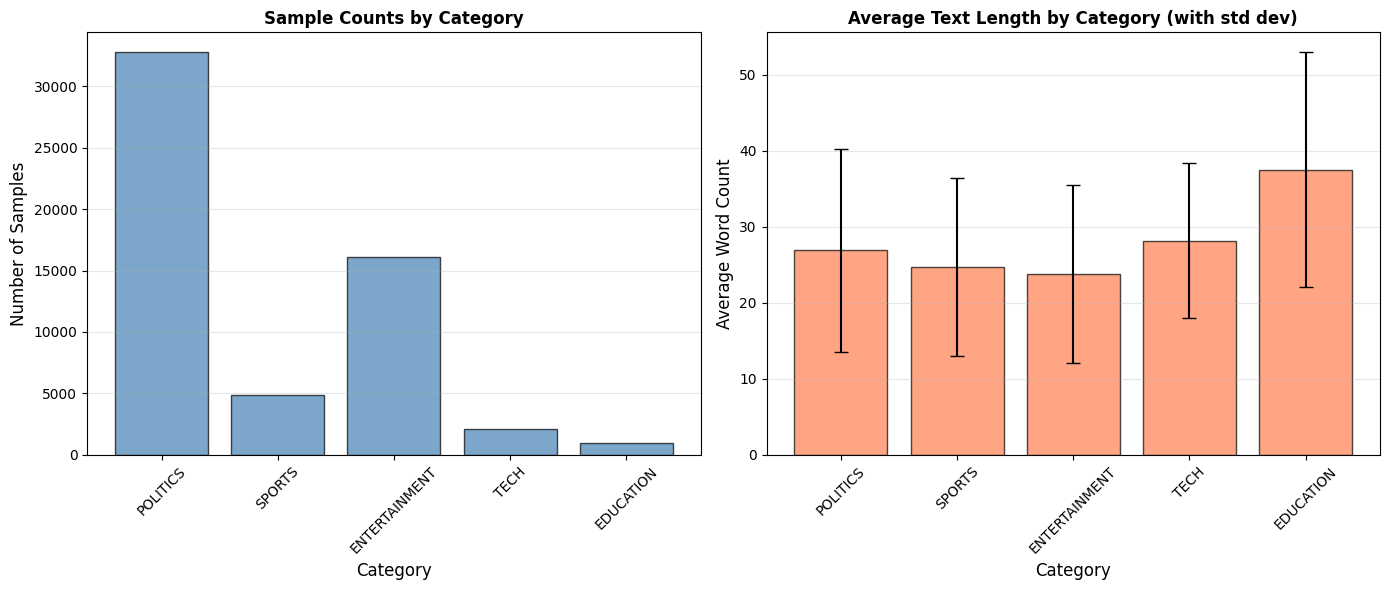

In [ ]:
# dataset visualizations
# Set style for better-looking plots
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Load the dataset
print("Loading HuffPost dataset...")
huff_all = load_from_disk("huffpost_splits")

# Load saved statistics
category_df = pd.read_csv('category_distribution.csv', index_col=0)
length_stats_df = pd.read_csv('text_length_stats.csv')

# visualization 1: class distributions
print("\n creating class distribution visualization...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# plot 1a: all categories
category_df.plot(kind='barh', y='count', ax=ax1, legend=False, color='steelblue')
ax1.set_xlabel('Number of Samples', fontsize=12)
ax1.set_ylabel('Category', fontsize=12)
ax1.set_title('Distribution of News Categories (All 41 Classes)', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(category_df['count']):
    ax1.text(v + 200, i, f'{v:,}', va='center', fontsize=8)

# Plot 1b: Top 15 categories only
top_15 = category_df.head(15)
top_15.plot(kind='barh', y='count', ax=ax2, legend=False, color='coral')
ax2.set_xlabel('Number of Samples', fontsize=12)
ax2.set_ylabel('Category', fontsize=12)
ax2.set_title('Top 15 Most Common Categories', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# Add value labels
for i, v in enumerate(top_15['count']):
    ax2.text(v + 200, i, f'{v:,}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('class_distribution.png', dpi=300, bbox_inches='tight')
print("Saved: class_distribution.png")
plt.show()

# visualization 2: class imbalance
print("Creating class imbalance visualization...")

fig, ax = plt.subplots(figsize=(10, 6))

# Sort by count
sorted_df = category_df.sort_values('count', ascending=True)

# Create color gradient based on count
colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(sorted_df)))

bars = ax.barh(range(len(sorted_df)), sorted_df['count'], color=colors)
ax.set_yticks(range(len(sorted_df)))
ax.set_yticklabels(sorted_df.index, fontsize=8)
ax.set_xlabel('Number of Samples', fontsize=12)
ax.set_title('Class Imbalance: All Categories Sorted by Frequency', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Add horizontal lines to show quartiles
median_count = sorted_df['count'].median()
ax.axvline(median_count, color='blue', linestyle='--', linewidth=2, label=f'Median ({median_count:.0f})')
ax.legend()

plt.tight_layout()
plt.savefig('class_imbalance.png', dpi=300, bbox_inches='tight')
print("Saved: class_imbalance.png")
plt.show()

# visualization 3: text length distributions
print("Creating text length distribution visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 3a: Headline lengths
axes[0, 0].hist(length_stats_df['headline_char_length'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Character Length', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('Distribution of Headline Lengths (Characters)', fontsize=12, fontweight='bold')
axes[0, 0].axvline(length_stats_df['headline_char_length'].median(), color='red', linestyle='--',
                    linewidth=2, label=f'Median: {length_stats_df["headline_char_length"].median():.0f}')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Plot 3b: Description lengths
axes[0, 1].hist(length_stats_df['description_char_length'], bins=50, color='lightgreen', edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Character Length', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].set_title('Distribution of Description Lengths (Characters)', fontsize=12, fontweight='bold')
axes[0, 1].axvline(length_stats_df['description_char_length'].median(), color='red', linestyle='--',
                    linewidth=2, label=f'Median: {length_stats_df["description_char_length"].median():.0f}')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Plot 3c: Combined text lengths
axes[1, 0].hist(length_stats_df['combined_char_length'], bins=50, color='lightcoral', edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Character Length', fontsize=11)
axes[1, 0].set_ylabel('Frequency', fontsize=11)
axes[1, 0].set_title('Distribution of Combined Text Lengths (Characters)', fontsize=12, fontweight='bold')
axes[1, 0].axvline(length_stats_df['combined_char_length'].median(), color='red', linestyle='--',
                    linewidth=2, label=f'Median: {length_stats_df["combined_char_length"].median():.0f}')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Plot 3d: Word counts
axes[1, 1].hist(length_stats_df['word_count'], bins=50, color='plum', edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Word Count', fontsize=11)
axes[1, 1].set_ylabel('Frequency', fontsize=11)
axes[1, 1].set_title('Distribution of Word Counts', fontsize=12, fontweight='bold')
axes[1, 1].axvline(length_stats_df['word_count'].median(), color='red', linestyle='--',
                    linewidth=2, label=f'Median: {length_stats_df["word_count"].median():.0f}')

# Add percentile lines
p95 = np.percentile(length_stats_df['word_count'], 95)
axes[1, 1].axvline(p95, color='orange', linestyle='--', linewidth=2, label=f'95th percentile: {p95:.0f}')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('text_length_distributions.png', dpi=300, bbox_inches='tight')
print("Saved: text_length_distributions.png")
plt.show()

# visualization 4: box plots for text lengths
print("Creating text length box plots...")

fig, ax = plt.subplots(figsize=(10, 6))

data_to_plot = [
    length_stats_df['headline_char_length'],
    length_stats_df['description_char_length'],
    length_stats_df['combined_char_length'],
    length_stats_df['word_count'] * 5  # Scale word count for better visualization
]

bp = ax.boxplot(data_to_plot, labels=['Headline\n(chars)', 'Description\n(chars)', 'Combined\n(chars)', 'Word Count\n(x5)'],
                patch_artist=True, notch=True, showmeans=True)

# Color the boxes
colors = ['skyblue', 'lightgreen', 'lightcoral', 'plum']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_ylabel('Length', fontsize=12)
ax.set_title('Text Length Statistics (Box Plots)', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('text_length_boxplots.png', dpi=300, bbox_inches='tight')
print("Saved: text_length_boxplots.png")
plt.show()

# visualization 5: Missing Data

print("Creating missing data visualization...")

missing_df = pd.read_csv('missing_data_stats.csv', index_col=0)
missing_df_filtered = missing_df[missing_df['pct_missing'] > 0]

if len(missing_df_filtered) > 0:
    fig, ax = plt.subplots(figsize=(10, 6))

    missing_df_filtered['pct_missing'].plot(kind='barh', ax=ax, color='salmon', edgecolor='black')
    ax.set_xlabel('Percentage Missing (%)', fontsize=12)
    ax.set_ylabel('Column', fontsize=12)
    ax.set_title('Missing Data by Column', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)

    # Add value labels
    for i, v in enumerate(missing_df_filtered['pct_missing']):
        ax.text(v + 0.2, i, f'{v:.2f}%', va='center', fontsize=10)

    plt.tight_layout()
    plt.savefig('missing_data.png', dpi=300, bbox_inches='tight')
    print("Saved: missing_data.png")
    plt.show()


# VISUALIZATION 6: Sample category comparison
print("Creating category sample comparison...")

# Select a few interesting categories to compare
categories_to_compare = ['POLITICS', 'SPORTS', 'ENTERTAINMENT', 'TECH', 'EDUCATION']
comparison_data = []

for cat in categories_to_compare:
    # Filter by category
    cat_indices = [i for i in range(len(huff_all)) if huff_all[i]['category'] == cat]
    cat_word_counts = [length_stats_df.loc[i, 'word_count'] for i in cat_indices]

    comparison_data.append({
        'category': cat,
        'count': len(cat_indices),
        'mean_words': np.mean(cat_word_counts),
        'median_words': np.median(cat_word_counts),
        'std_words': np.std(cat_word_counts)
    })

comparison_df = pd.DataFrame(comparison_data)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot sample counts
ax1.bar(comparison_df['category'], comparison_df['count'], color='steelblue', edgecolor='black', alpha=0.7)
ax1.set_ylabel('Number of Samples', fontsize=12)
ax1.set_xlabel('Category', fontsize=12)
ax1.set_title('Sample Counts by Category', fontsize=12, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

# Plot mean word counts
ax2.bar(comparison_df['category'], comparison_df['mean_words'], color='coral', edgecolor='black', alpha=0.7,
        yerr=comparison_df['std_words'], capsize=5)
ax2.set_ylabel('Average Word Count', fontsize=12)
ax2.set_xlabel('Category', fontsize=12)
ax2.set_title('Average Text Length by Category (with std dev)', fontsize=12, fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('category_comparison.png', dpi=300, bbox_inches='tight')
print("Saved: category_comparison.png")
plt.show()

In [ ]:
from collections import Counter, defaultdict
import re

# overlap comparison

# Load category distribution
category_df = pd.read_csv('category_distribution.csv', index_col=0)

print("\n" + "-"*80)
print("category overlap and ambiguity analysis")
print("-"*80)

# identify similar category names
print("\nPotentially Overlapping Categories (Similar Names)")

# list all categories
categories = list(category_df.index)

# find similar category names
overlapping_groups = []

# Manual identification of potential overlaps
potential_overlaps = [
    ['ARTS', 'ARTS & CULTURE', 'CULTURE & ARTS'],
    ['STYLE', 'STYLE & BEAUTY'],
    ['HOME & LIVING', 'HEALTHY LIVING'],
    ['PARENTS', 'PARENTING'],
    ['THE WORLDPOST', 'WORLDPOST', 'WORLD NEWS'],
    ['FOOD & DRINK', 'TASTE'],
    ['WELLNESS', 'HEALTHY LIVING'],
    ['WOMEN', 'FIFTY'],  # Fifty is about 50+ demographics, often overlaps with women's content
    ['BUSINESS', 'MONEY', 'TECH'],
    ['POLITICS', 'THE WORLDPOST', 'WORLD NEWS'],
    ['ENVIRONMENT', 'GREEN'],
    ['COMEDY', 'WEIRD NEWS'],
]

for group in potential_overlaps:
    existing = [cat for cat in group if cat in categories]
    if len(existing) > 1:
        print(f"Overlapping group: {existing}")
        for cat in existing:
            count = category_df.loc[cat, 'count']
            print(f"  - {cat}: {count:,} samples")
        print()

# analys vocabulary overlap between categories
print("\n" + "-"*80)
print("Vocabulary Overlap Analysis")

# Build vocabulary for each category
print("\nBuilding category-specific vocabularies...")

category_vocabularies = defaultdict(Counter)
category_samples = defaultdict(list)

# Create combined texts and group by category
for i in range(len(huff_all)):
    cat = huff_all[i]['category']
    headline = (huff_all[i].get('headline') or '').strip()
    desc = (huff_all[i].get('short_description') or '').strip()
    combined = f"{headline} {desc}".lower()

    # Clean and tokenize
    words = re.findall(r'\b[a-z]+\b', combined)

    category_vocabularies[cat].update(words)
    if len(category_samples[cat]) < 5:  # Keep first 5 samples
        category_samples[cat].append({
            'headline': headline,
            'description': desc
        })

# Calculate top words per category (excluding common stop words)
common_stopwords = {'the', 'a', 'to', 'of', 'and', 'in', 'is', 'for', 'that',
                   'on', 'you', 'with', 'it', 'are', 'this', 'be', 'at', 'by',
                   'as', 'your', 'from', 'or', 'an', 'was', 'but', 'not', 'have',
                   'had', 'has', 'we', 'they', 'he', 'she', 'will', 'more', 'if'}

print("\nTop distinctive words per category (first 10 categories):\n")

for i, cat in enumerate(list(categories)[:10]):
    vocab = category_vocabularies[cat]
    # Filter out stopwords
    filtered_vocab = {word: count for word, count in vocab.items()
                     if word not in common_stopwords and len(word) > 2}

    top_words = sorted(filtered_vocab.items(), key=lambda x: x[1], reverse=True)[:10]

    print(f"{cat}:")
    print(f"  Top words: {', '.join([w for w, c in top_words])}")
    print()

# find confusing category pairs
print("\n" + "-"*80)
print("Potentially Confusing Category Pairs")
print("-"*80)

# Analyze specific confusing pairs
confusing_pairs = [
    ('POLITICS', 'THE WORLDPOST'),
    ('POLITICS', 'WORLD NEWS'),
    ('THE WORLDPOST', 'WORLD NEWS'),
    ('ARTS', 'ARTS & CULTURE'),
    ('ARTS & CULTURE', 'CULTURE & ARTS'),
    ('STYLE', 'STYLE & BEAUTY'),
    ('PARENTS', 'PARENTING'),
    ('WELLNESS', 'HEALTHY LIVING'),
    ('ENVIRONMENT', 'GREEN'),
    ('BUSINESS', 'MONEY'),
    ('FOOD & DRINK', 'TASTE'),
]

print("\nAnalyzing vocabulary overlap for confusing pairs:\n")

for cat1, cat2 in confusing_pairs:
    if cat1 not in categories or cat2 not in categories:
        continue

    vocab1 = set(category_vocabularies[cat1].keys())
    vocab2 = set(category_vocabularies[cat2].keys())

    # Calculate Jaccard similarity (intersection / union)
    intersection = vocab1 & vocab2
    union = vocab1 | vocab2
    jaccard = len(intersection) / len(union) if len(union) > 0 else 0

    print(f"{cat1} vs {cat2}:")
    print(f"  Jaccard similarity: {jaccard:.3f}")
    print(f"  Shared unique words: {len(intersection):,}")
    print(f"  {cat1} samples: {category_df.loc[cat1, 'count']:,}")
    print(f"  {cat2} samples: {category_df.loc[cat2, 'count']:,}")
    print()

# sample examples from ambiguous categories
print("\n" + "-"*80)
print("Sample Examples from Ambiguous Categories")
print("-"*80)

ambiguous_categories = [
    'THE WORLDPOST',
    'WORLD NEWS',
    'ARTS & CULTURE',
    'CULTURE & ARTS',
    'HEALTHY LIVING',
    'WELLNESS'
]

for cat in ambiguous_categories:
    if cat not in categories:
        continue

    print(f"\n{cat} (sample examples):")
    print("-" * 60)

    samples = category_samples[cat]
    for i, sample in enumerate(samples[:3], 1):
        print(f"  Example {i}:")
        print(f"    Headline: {sample['headline'][:80]}...")
        print(f"    Description: {sample['description'][:100]}...")
        print()


# save results
print("\n" + "-"*80)
print("Saving Overlap Analysis Results")
print("-"*80)

# Create summary of potentially overlapping groups
overlap_summary = []
for group in potential_overlaps:
    existing = [cat for cat in group if cat in categories]
    if len(existing) > 1:
        total_samples = sum(category_df.loc[cat, 'count'] for cat in existing)
        overlap_summary.append({
            'group': ', '.join(existing),
            'num_categories': len(existing),
            'total_samples': total_samples,
            'categories': '|'.join(existing)
        })

overlap_df = pd.DataFrame(overlap_summary)
overlap_df.to_csv('category_overlaps.csv', index=False)
print("Saved category overlap analysis to 'category_overlaps.csv'")


--------------------------------------------------------------------------------
category overlap and ambiguity analysis
--------------------------------------------------------------------------------

Potentially Overlapping Categories (Similar Names)
Overlapping group: ['ARTS', 'ARTS & CULTURE', 'CULTURE & ARTS']
  - ARTS: 1,509 samples
  - ARTS & CULTURE: 1,339 samples
  - CULTURE & ARTS: 1,030 samples

Overlapping group: ['STYLE', 'STYLE & BEAUTY']
  - STYLE: 2,254 samples
  - STYLE & BEAUTY: 9,649 samples

Overlapping group: ['HOME & LIVING', 'HEALTHY LIVING']
  - HOME & LIVING: 4,195 samples
  - HEALTHY LIVING: 6,694 samples

Overlapping group: ['PARENTS', 'PARENTING']
  - PARENTS: 3,955 samples
  - PARENTING: 8,677 samples

Overlapping group: ['THE WORLDPOST', 'WORLDPOST', 'WORLD NEWS']
  - THE WORLDPOST: 3,664 samples
  - WORLDPOST: 2,579 samples
  - WORLD NEWS: 2,177 samples

Overlapping group: ['FOOD & DRINK', 'TASTE']
  - FOOD & DRINK: 6,226 samples
  - TASTE: 2,096 sample

### Graded Questions (2 pts each) (Peter)

For each question, answer thoroughly but concisely, in a short paragraph, longer or shorter as needed. Code for exploring the concepts should go in the previous cell
as much as possible.

1. **Dataset Summary:**  
   Describe your chosen dataset  (as if explaining to your *clueless boss* what you are working on).
   - State which dataset you are going to use.   
   - What kind of data does it contain (images or text)?  
   - How many samples and classes are there?  
   - What is the task you’ll perform (classification into what categories)?
   - What is the potential business use for this dataset?

1.1. **Your answer here:**

We are using the **HuffPost News Category Dataset**, which contains text data from online news articles published by HuffPost. The dataset includes **200,853 samples** across **41 distinct news topic categories** such as POLITICS, WELLNESS, ENTERTAINMENT, SPORTS, TECH, and others.

Each sample consists of a news article **headline** and a **short description** (summary), which we concatenate with a `[SEP]` separator token to create the input text: `"headline [SEP] short_description"`.

The task is to perform **multi-class text classification**: given a news headline and short description, predict which of the 41 topical categories the article belongs to.

**Potential business uses** include:
- **Automated content categorization** for news aggregators and publishing platforms
- **Improving news recommendation algorithms** to personalize user feeds
- **Editorial workflow automation** by auto-tagging articles during the publishing process
- **Content analytics and trend detection** to understand what topics are gaining traction
- **Advertising targeting** by matching ads to relevant content categories

2. **Initial Observations:**  
   What stood out to you from your EDA?  
   - Did you notice any imbalanced or ambiguous classes?  
   - Any patterns, anomalies, or potential sources of bias?  
   - For images: note any variation in lighting, composition, or color.  
   - For text: mention redundancy, topic overlap, or very short examples.

1.2. **Your answer here:**

Several important patterns emerged from the exploratory data analysis:

**Class Imbalance:** The dataset is significantly imbalanced with a **32:1 ratio** between the largest and smallest classes. POLITICS dominates with 32,739 samples (16.3% of the dataset), while EDUCATION has only 1,004 samples (0.5%). Ten categories have fewer than 2,000 samples each (less than 1% of the total), which may lead to poor model performance on these minority classes.

**Overlapping and Ambiguous Categories:** Multiple category groups have similar or overlapping content with high vocabulary overlap. Notable examples include:
- **THE WORLDPOST, WORLDPOST, and WORLD NEWS** (40% Jaccard similarity) appear to cover the same international news topic with inconsistent naming
- Three variations of arts coverage: **ARTS, ARTS & CULTURE, and CULTURE & ARTS**
- **WELLNESS and HEALTHY LIVING** share 39% of their vocabularies
- **PARENTS and PARENTING** are essentially duplicate categories (37% similarity)

These overlaps will likely cause confusion in model predictions and reduce accuracy.

**Missing Data:** About **10% of samples are missing the short_description field**, and 18% are missing author information. This results in less informative input text for those samples, as they will only contain headlines.

**Text Characteristics:** Articles are quite short (median **29 words**, mean 30 words), which limits the contextual information available to the model. However, this also means minimal truncation will be needed—only 0.08% of samples exceed 128 tokens. The vocabulary is diverse with 239,961 unique tokens across 200k documents.

**Data Quality Issues:** We found **488 exact duplicate texts (0.24%)** and **1,509 duplicate headlines (0.75%)**, suggesting some redundant content that should be handled during preprocessing to prevent data leakage between train/validation/test splits.



3. **Challenges & Implications:**  
   Based on your inspection, what challenges might affect model performance or training (e.g., imbalance, ambiguous labels, variable quality)?  

1.3. **Your answer here:**

The identified issues may affect model performance in several ways:

**1. Class Imbalance Impact:**
The severe imbalance (32:1 ratio) means the model may become biased toward majority classes like POLITICS and WELLNESS. Minority classes such as EDUCATION, COLLEGE, and LATINO VOICES may have poor prediction accuracy since the model sees so few training examples. Standard accuracy metrics could be misleading if the model simply predicts majority classes—achieving 16% accuracy by always predicting "POLITICS" sets a very low bar. This requires careful use of stratified splitting, class-weighted loss functions, and macro-averaged metrics.

**2. Category Ambiguity and Overlap:**
The model will likely struggle to distinguish between similar categories. For example, THE WORLDPOST vs WORLD NEWS have 40% vocabulary overlap—the model may arbitrarily assign articles to one or the other. Similarly, WELLNESS/HEALTHY LIVING and PARENTS/PARENTING pairs will be difficult to discriminate. This could inflate the confusion matrix and reduce overall F1 scores, particularly for these overlapping categories.

**3. Limited Context from Short Texts:**
With an average of only 30 words per sample, the model has limited semantic information to work with. Simple bag-of-words or TF-IDF approaches may struggle to capture sufficient meaning. This suggests we'll need powerful pretrained embeddings (BERT, DistilBERT) rather than classical methods. The 10% of samples missing descriptions further reduces available context.

**4. Data Quality Concerns:**
Duplicate texts could leak between train/validation/test sets if not handled carefully, inflating performance metrics artificially. Missing descriptions create inconsistent input representations—some samples have rich context while others are headline-only. This variability may confuse the model during training.

**5. Evaluation Challenges:**
Simple accuracy will not reflect true performance due to imbalance. A model that always predicts "POLITICS" achieves 16.3% accuracy but is useless. We need macro-averaged F1 score to give equal weight to all classes, and per-class metrics are essential to identify which categories struggle. The confusion matrix will be critical for understanding where category overlap causes problems.

4. **Preparation Ideas:**  
   What data-cleaning or preprocessing steps might help address these issues?  
   (You will not implement these yet—just describe what you might do later.)

1.4. **Your answer here:**

To address the identified challenges, the following preprocessing and modeling strategies are recommended:

**1. Category Consolidation:**
Merge obviously overlapping categories to reduce confusion and improve label consistency. This consolidation would reduce the problem from the original classes to a tailored set with clearer boundaries and less overlap.

**2. Handle Class Imbalance:**
- Use **stratified train/val/test splits** to maintain class distribution proportionally, and use class weighting in the loss function to penalize missclassification of minority classes more heavily.

**3. Text Preprocessing:**
- Create combined text field: `"headline [SEP] short_description"`, apply lowercase normalization, and remove exact duplicates

**4. Tokenization Strategy:**
- Use a **pretrained transformer tokenizer** (DistilBERT or BERT-base-uncased), set max sequence length to 128 tokens (99.92% coverage), use padding to handle variable lengths uniformly.

5. **Reflection:**  
   Why did you choose this dataset over the other one?  
   - What makes it more interesting, realistic, or relevant for you?  
   - What do you expect to learn from working with it?

1.5. **Your answer here:**
We chose the **HuffPost News Category Dataset** over Food-101 for the following reasons:
1. Text classification is a fundamental skill that is very common in modern data science.
2. The overlapping/messy class distribution creates an interesting challenge representing a real-world issue we might encounter.
3. We expect to learn how to handle severely imbalanced multi-classifcation tasks, use pretrained language models effectively, practice preprocessing and tokenization strategies, deal with the ambiguous and overlapping category issue in our label design.
4. From a practical standpoint, this dataset is easier to work with computationally, especially when working with my team across multiple machines and environments.


## Problem 2 – Frame the Problem (15 pts) (August w/ Emma reviewing code)

#### Objective

Identify the **key challenges** in your chosen dataset and outline **practical solutions** you would try, plus how you’ll **evaluate** them later.

#### Steps to follow

1. **Diagnose likely challenges (from your EDA):**

   Examples:
   * **Class imbalance:**
     Report label counts and an imbalance ratio (max / median). List any minority classes.
   * **Length/size variance:**
     For text, show length percentiles (50/75/90/95) and estimate truncation rate at candidate `max_text_length`s (e.g., 256/300/512). For images, summarize native resolutions.
   * **Noise/duplicates/leakage:**
     Note empty or malformed items, near-duplicates, and how you would prevent cross-split leakage.
   * **Ambiguous/overlapping labels:**
     Give 2–3 example pairs you expect to be confusable and why.
   * **Compute constraints:**
     Briefly state limits (RAM/GPU/CPU) that might affect batch size, sequence length, or image size.

2. **Map each challenge to a concrete solution plan:**

   Examples:
   * **Imbalance →** `class_weight` or oversampling; report which one you’d try first and why.
   * **Length/size →** pick a target `max_text_length` (e.g., 95th percentile) with masking; for images, standardize resize/crop and basic augmentation.
   * **Noise/duplicates →** dedupe (hash/near-dup), drop empty/very short items, document any relabeling.
   * **Ambiguity →** consider merging labels (if justified), or add features (bigrams/char-ngrams; simple image augmentations).
   * **Overfitting risk →** early stopping on your primary metric, dropout/weight decay, freeze-then-finetune plan (for pretrained features).

3. **Explore appropriate evaluation metrics:**

   Examples:
   * **Primary metric:** pick one aligned to your data (e.g., **macro-F1** if imbalanced; accuracy if balanced).
   * **Secondary metric(s):** per-class precision/recall, confusion matrix.
   * **Protocol:** stratified Train/Val/Test (e.g., 70/15/15), fixed seed, leakage checks.

4. **Answer the graded questions below.**



## [Problem 2] Frame the Problem (Answers)


### **[Problem 2.1] Key Patterns and Challenges from EDA**

| Challenge                          | Evidence / Finding                                                                                                     | Impact                                                          |
| ---------------------------------- | ---------------------------------------------------------------------------------------------------------------------- | --------------------------------------------------------------- |
| **Class imbalance**                | POLITICS = 32,739 samples (16.3%); EDUCATION = 1,004 (0.5%). Imbalance ≈ 32 : 1.                                       | Model may overfit majority classes, underperform on small ones. |
| **Overlapping / ambiguous labels** | High Jaccard overlap between *WORLD NEWS ↔ THE WORLDPOST ↔ WORLDPOST* (~0.40) and *WELLNESS ↔ HEALTHY LIVING* (~0.39). | Model confusion between semantically similar topics.            |
| **Missing data**                   | ~10 % missing `short_description`; 18 % missing `authors`.                                                             | Reduced context in some samples; inconsistent input quality.    |
| **Short text length**              | Median = 29 words; Mean = 30 words. Only 0.08 % exceed 128 tokens.                                                     | Limited semantic content; contextual models needed.             |
| **Duplicates / leakage risk**      | 488 duplicate texts (0.24 %) and 1,509 duplicate headlines (0.75 %).                                                   | Could inflate test accuracy if duplicates leak across splits.   |
| **Computational constraints**      | Moderate: dataset fits in memory; BERT-base (512 max) feasible; prefer ≤ 128 tokens to speed training.                 | Guides model and batch-size choice.                             |

---

### **Impact of These Issues on Model Performance**

1. **Class imbalance** – Without correction, the model will bias toward large classes (e.g., *POLITICS*). Minority topics (*EDUCATION*, *LATINO VOICES*) will have poor recall and low F1. Overall accuracy may look high but be misleading.

2. **Category ambiguity** – Overlapping categories cause label noise. A model may confuse *WORLD NEWS* vs. *THE WORLDPOST*, reducing macro-F1 and inflating confusion-matrix off-diagonals.

3. **Short / missing text** – Headline-only samples convey little semantic information. Classical vectorizers (TF-IDF) may fail; transformer embeddings are better suited.

4. **Duplicates and leakage** – If near-identical samples appear in multiple splits, test results become over-optimistic. Dedupe and stratify before splitting.

5. **Evaluation distortion** – Due to imbalance, **accuracy** will overstate performance. **Macro-F1** and per-class recall are more appropriate.

---

### **[Problem 2.2] Planned Solutions and Modeling Strategy**

| Challenge                | Planned Solution                                                                                                                                                                                          |
| ------------------------ | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Class imbalance**      | Use **stratified train/val/test split (70/15/15)** to preserve ratios. Apply **class-weighted loss** (cross-entropy with weights ∝ 1/freq). Consider oversampling minority classes if imbalance persists. |
| **Category overlap**     | **Merge** or relabel near-duplicate categories (e.g., merge *WORLD NEWS* + *THE WORLDPOST*). Document mapping to ensure reproducibility.                                                                  |
| **Short/missing text**   | Use combined field `"headline [SEP] short_description"`. Drop rows missing both; retain headline-only rows.                                                                                               |
| **Duplicates / leakage** | Identify duplicates via hashing of combined text; remove before split to avoid leakage.                                                                                                                   |
| **Text length choice**   | Tokenize with **BERT-base-uncased** or **DistilBERT**. `max_length = 128` (covers > 99.9 % of samples). Pad/truncate as needed.                                                                           |
| **Overfitting control**  | Apply dropout, early stopping on validation macro-F1, weight decay = 0.01, and freeze lower layers initially (“freeze-then-finetune”).                                                                    |

---

### **[Problem 2.3] Evaluation Metrics Plan**

| Aspect                | Decision                                                                  |
| --------------------- | ------------------------------------------------------------------------- |
| **Primary metric**    | **Macro-F1** — treats all 41 classes equally, robust to imbalance.        |
| **Secondary metrics** | Per-class Precision / Recall, Confusion Matrix, and Weighted F1.          |
| **Data split**        | Stratified **70 / 15 / 15** (Train / Val / Test), fixed random seed = 42. |
| **Baseline**          | Majority-class baseline (predict “POLITICS” ≈ 16 % accuracy).             |
| **Advanced models**   | Compare TF-IDF + LogReg vs. DistilBERT fine-tune; evaluate gains.         |
| **Fairness check**    | Track F1 by category group to ensure minority topics improve.             |

---




In [ ]:
# install evaluate
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.6 MB/s eta 0:00:00


In [ ]:
# Emma Cleanup:

# Imports
import pandas as pd
import numpy as np
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)
import torch
import evaluate
import transformers
from transformers import TrainingArguments, AutoTokenizer, AutoModelForSequenceClassification, Trainer, EarlyStoppingCallback
from sklearn.preprocessing import LabelEncoder
from torch.nn import CrossEntropyLoss

# Dataset reload & split selection
from datasets import load_from_disk
huff_all = load_from_disk("huffpost_splits")


# combine headline & short_description into 1 text field

def combine_fields(prob2):
  headline = prob2.get('headline', '') or ""
  short_desc = prob2.get('short_description', '[NO_DESC]') or "[NO_DESC]"
  prob2['text'] = f"{headline} [SEP] {short_desc}"
  return prob2

huff_all = huff_all.map(combine_fields)
print(huff_all.column_names)
print(huff_all[0])

df_prob2 = huff_all.to_pandas()


Map:   0%|          | 0/200853 [00:00<?, ? examples/s]

['category', 'headline', 'authors', 'link', 'short_description', 'date', 'text']
{'category': 'CRIME', 'headline': 'There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV', 'authors': 'Melissa Jeltsen', 'link': 'https://www.huffingtonpost.com/entry/texas-amanda-painter-mass-shooting_us_5b081ab4e4b0802d69caad89', 'short_description': 'She left her husband. He killed their children. Just another day in America.', 'date': datetime.datetime(2018, 5, 26, 0, 0), 'text': 'There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV [SEP] She left her husband. He killed their children. Just another day in America.'}


In [ ]:
# Emma Cleanup cont:

# Solution 1: Merge Duplicate/Overlapping Categories
merge_map = {
    'WORLDPOST': 'WORLD NEWS',
    'ARTS': 'ARTS & CULTURE',
    'ARTS & CULTURE': 'CULTURE & ARTS',
    'STYLE': 'STYLE & BEAUTY',
    'PARENTS': 'PARENTING'
    }
df_prob2['category'] = df_prob2['category'].replace(merge_map)

# Solution 2: Handle Missing short_description
df_prob2['short_description'] = df_prob2['short_description'].replace('','[NO_DESC]').fillna('[NO_DESC]')

# Solution 3: Combine headline and short_description into a single field to avoid short text length
df_prob2['headline'] = df_prob2['headline'].fillna('')
df_prob2['text'] = df_prob2['headline'] + " [SEP] " + df_prob2['short_description']

# Solution 4: Deduplicating
df_prob2 = df_prob2.drop_duplicates(subset=["text"]).reset_index(drop=True)

# Solution 5: Stratified Split with train/val/test/split
train_df, temp_df = train_test_split(
    df_prob2,
    test_size=0.30,
    stratify=df_prob2['category'],
    random_state=42
)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,  # Split temp equally into val/test (15% each of total)
    stratify=temp_df['category'],
    random_state=42
)

# convert splits back to Hugging Face Datasets
train_ds = Dataset.from_pandas(train_df[['text', 'category']])
val_ds   = Dataset.from_pandas(val_df[['text', 'category']])
test_ds  = Dataset.from_pandas(test_df[['text', 'category']])


# Solution 6: Compute/Apply Class Weights to handle Imbalance
categories = np.unique(df_prob2['category'])
weights = compute_class_weight(
    class_weight='balanced',
    classes=categories,
    y=df_prob2['category']
)

class_weights = torch.tensor(weights, dtype=torch.float)
print('\nClass weights examples:')
print(dict(zip(categories[:5], weights[:5])))

# Solution 7: Tokenization with DistilBERT & max_length=128

model_name = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_fn(batch):
  return tokenizer(
      batch['text'],
      padding='max_length',
      truncation=True,
      max_length=128
  )
train_ds = train_ds.map(tokenize_fn, batched=True)
val_ds   = val_ds.map(tokenize_fn, batched=True)
test_ds  = test_ds.map(tokenize_fn, batched=True)


# Solution 8: Label Encode category column into integers

le = LabelEncoder()
all_labels = list(train_ds['category']) + list(val_ds['category']) + list(test_ds['category'])
le.fit(all_labels)
num_labels = len(le.classes_)

def encode_labels(batch):
    batch['labels'] = le.transform([batch['category']])[0]
    return batch

train_ds = train_ds.map(encode_labels)
val_ds   = val_ds.map(encode_labels)
test_ds  = test_ds.map(encode_labels)

# Solution 9: Freeze Backbone & Add Dropout

model=AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels, dropout=0.2)
for param in model.distilbert.parameters():
    param.requires_grad = False

# Solution 10: Define Weighted Trainer
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = CrossEntropyLoss(weight=class_weights.to(model.device))
        loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

#Solution 9: Select Efficient Learning Rate, Weight Decay, FP16, and Batch Size
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=3e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True
)

# Solution 10: Add Early Stopping
early_stopping = EarlyStoppingCallback(early_stopping_patience=3)

# Model Setup:
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    callbacks=[early_stopping]
)





Class weights examples:
{'BLACK VOICES': np.float64(1.230531603901049), 'BUSINESS': np.float64(0.9380910912598086), 'COLLEGE': np.float64(4.865117521367521), 'COMEDY': np.float64(1.077787460194509), 'CRIME': np.float64(1.6364876343559085)}


Map:   0%|          | 0/140255 [00:00<?, ? examples/s]

Map:   0%|          | 0/30055 [00:00<?, ? examples/s]

Map:   0%|          | 0/30055 [00:00<?, ? examples/s]

Map:   0%|          | 0/140255 [00:00<?, ? examples/s]

Map:   0%|          | 0/30055 [00:00<?, ? examples/s]

Map:   0%|          | 0/30055 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-4287778214.py:124: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


In [ ]:
# Your code here, add as many cells as you like. Provide organization and structure by appropriate comments, labels, and variable names. Explain what
# you are doing in case you come back to this in a year.


# #In [Milestone 1, Problem 2], we are only framing the problem & not implementing code yet

# # ============================================
# # Problem 2: Framing and Preprocessing Setup
# # HuffPost News Category Classification
# # ============================================

# # --- Imports ---
# import pandas as pd
# import numpy as np
# from datasets import Dataset
# from sklearn.model_selection import train_test_split
# from sklearn.utils.class_weight import compute_class_weight


# print(f"Total examples in dataset: {len(category_df):,}")
# print(f"Number of unique categories: {category_df['category'].nunique()}")

# #Compute imbalance ratio
# imbalance_ratio = category_counts.max() / category_counts.median()
# print(f"\nImbalance ratio (max/median): {imbalance_ratio:.2f}")

# #--- Compute class weights for model training ---
# classes = np.array(category_counts.index)
# weights = compute_class_weight(class_weight='balanced', classes=classes, y=df['category'])
# class_weights = dict(zip(classes, weights))
# print("\nClass weights computed (sample 5 categories):")
# print(dict(list(class_weights.items())[:5]))

# #--- Split dataset into train, validation, and test sets ---
# train_df, temp_df = train_test_split(
#     category_df,
#     test_size=0.30,  # 70% train, 30% temp
#     stratify=category_df['category'],
#     random_state=42
# )

# val_df, test_df = train_test_split(
#     temp_df,
#     test_size=0.50,  # Split temp equally into val/test (15% each of total)
#     stratify=temp_df['category'],
#     random_state=42
# )

# print(f"\nTrain: {len(train_df):,} | Val: {len(val_df):,} | Test: {len(test_df):,}")
# print("\nClass distribution in train set:")
# print(train_df['category'].value_counts(normalize=True).head())

# # --- Convert to Hugging Face Datasets ---
# train_ds = Dataset.from_pandas(train_df[['text', 'category']])
# val_ds   = Dataset.from_pandas(val_df[['text', 'category']])
# test_ds  = Dataset.from_pandas(test_df[['text', 'category']])

# # --- Save datasets to disk (optional) ---
# train_ds.save_to_disk("huffpost_train_cleaned")
# val_ds.save_to_disk("huffpost_val_cleaned")
# test_ds.save_to_disk("huffpost_test_cleaned")


In [ ]:
#In [Milestone 1, Problem 2], we are only framing the problem & not implementing code yet
#The following below are possible codes for evaluation metrics

# ============================================
# Evaluation Metrics for HuffPost Classification
# ============================================

# import numpy as np
# from sklearn.metrics import (
#     accuracy_score,
#     f1_score,
#     precision_recall_fscore_support,
#     confusion_matrix
# )
# import pandas as pd

# # --------------------------------------------------------------------
# # Hugging Face Trainer-compatible compute_metrics() function
# # --------------------------------------------------------------------
# def compute_metrics(eval_pred):
#     """
#     Computes Accuracy, Macro-F1, Weighted-F1, and per-class metrics.
#     Designed for use with Hugging Face Trainer.
#     """
#     logits, labels = eval_pred
#     preds = np.argmax(logits, axis=-1)

#     # Basic metrics
#     acc = accuracy_score(labels, preds)
#     macro_f1 = f1_score(labels, preds, average='macro')
#     weighted_f1 = f1_score(labels, preds, average='weighted')

#     # Detailed per-class metrics (for analysis after training)
#     precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average=None)

#     # Build dictionary for Trainer + optional detailed results
#     metrics = {
#         "accuracy": acc,
#         "macro_f1": macro_f1,
#         "weighted_f1": weighted_f1,
#     }

#     # Optional: save per-class results after evaluation
#     try:
#         label_names = trainer.model.config.id2label  # if available
#         per_class_df = pd.DataFrame({
#             "label": [label_names[i] for i in range(len(precision))],
#             "precision": precision,
#             "recall": recall,
#             "f1": f1
#         })
#         per_class_df.to_csv("per_class_metrics.csv", index=False)
#     except Exception:
#         pass  # safe fallback if id2label not set

#     return metrics


In [ ]:
!git status




fatal: not a git repository (or any of the parent directories): .git


### Graded Questions (3 pts each) (Emma)

For each question, answer thoroughly but concisely, in a short paragraph, longer or shorter as needed. Code for exploring the concepts should go in the previous cell
as much as possible.

1. **State the prediction task**  
   - Describe what your model will predict (the *label*).  
   - *Examples:*  
     - “Given a photo of food, predict which of 101 categories it belongs to.”  
     - “Given a news headline + summary, predict its topical category.”  

2.1. **Your answer here:**


Our model predicts the category of each HuffPost article which will group articles based upon the topic they belong to. The model takes in text input of the headline and short_description, or a short summary of the article, and maps them into one of the categories which generates a label. This process is referred to as single-label multi-class text classification.

2. **Define inputs and outputs**  
   - *Inputs:* what information the model receives (e.g., pixel data, tokenized text).  
   - *Outputs:* the categorical label the model will predict.  

2.2. **Your answer here:**


Inputs: The model receives text data from each news article including a headline and a short description or summary of the article. These two inputs are combined into one string and then tokenized using BERT or DistilBERT in our case. This process converts the string into numerical tensors including input_ids which are the IDs representing the words and attention_mask which tells us which tokens are real text or padding produced. As designated by the decision to set the maximum length to 128, each input is truncated at 128 tokens.


Outputs: The model outputs one single categorical label that describes the topic of the article. The model will also output a probability distribution for all the possible categories to indicate the highest probability for each article.





3. **Identify possible challenges**  
   - Imbalanced classes, noisy data, ambiguous labels, overlapping features, or missing data  
   - *Images:* variation in lighting, color, composition, or size.  
   - *Text:* class imbalance, duplicate stories, short or ambiguous headlines.  

2.3. **Your answer here:**


As previously mentioned in Problem 1, there are quite a few potential challenges associated with training this model.

*   The classes in the dataset are imbalanced with a 32:1 ratio between the largest and the smallest classes which may lead to poor model performance on these minority classes resulting in a lower macro-F1 score and lower revall for these underrepresented topics.
*   Many categories are nearly duplicated and contain overlapping content which can confuse model predictions and reduce overall accuracy.

*   About 10% of the samples are missing the short_description field and 18% are missing author information which results in significantly less context for the model to use and therefore can ultimately mislead the model.



*   The median text length is 29 which limits the contextual information available to the model which can ultimately lead to missed understanding of nuanced or challenging topics.


*   There are 488 exact duplicate texts and 1,509 duplicate headlines which indicates redundant content and data quality issues that could potentially result in data leakage and over-performing test metrics.


*   Humans often create label noise by multi-topic categorization in label headlines. Headlines often touch on more than one categorical topic which can be difficult for the model to interpret.

*   BERT is a large transformer and can be slow.







4. **Propose how you will prepare or improve the data to address the challenges**  
   - *Images:* resizing, normalization, data augmentation (flips, rotations, brightness, color jitter).  
   - *Text:* tokenization, stop-word removal, TF-IDF, class balancing, embeddings (choose an embedding approach and specify its vector size).

2.4. **Your answer here:**

*  To handle class imbalance, our team plans to stratify the training, testing, and validation splits as well as apply class-weighted cross-entropy loss so the categories with very few samples have similar training influence despite their small size.

*   To resolve the ambiguous and overlapping labels, we plan to merge these semantically similar labels including but not limited to: "THE WORLDPOST:WORLD NEWS", "WELLNESS:HEALTHY LIVING", and "PARENTS:PARENTING".

*   To resolve the limited context from short description field, our team will use pre-trained BERT (DistilBERT) to handle these missing descriptors. We will also drop any articles in the database missing both the headline and the description.

*   The headlines and short descriptions are too brief to give enough context to the model, so these values will be concatenated to provide more context.

*   To resolve the issue of duplicated texts and headlines, these duplicates will be removed to prevent data leakage.

*   To handle the difficulty in coercing the model to select only one category despite the potential for multi-topic categorization in headlines, tokenization with DistilBERT will be used to detect subwords and handle these difficult scenarios.

*   The model will use label encoding to normalize and convert category strings to numeric IDs to ensure compatibility with classification.

*   Finally, hyperparameter tuning or model-level adjustments can be can be made to mitigate overfitting. Some of these techniques include freezing the head initially, implement dropout and weight decay to regularize the model, and apply early stopping to prevent overfitting.










5. **Specify success metrics**  
   - Identify the metrics you plan to use to evaluate model performance—typically **accuracy** and/or **F1-score**, which are standard for classification tasks.  
   - Briefly explain **why** these metrics are appropriate for your dataset and goal. For instance, accuracy may suffice for well-balanced datasets, while F1-score better reflects performance when some classes are under-represented.
   - If your dataset is **imbalanced**, consider computing **per-class metrics** (e.g., precision, recall, or F1 for each label) or **macro-averaged** scores, which give equal weight to each class regardless of its size—ensuring that minority classes are evaluated fairly.
In some cases, weighted averages (which weight classes by their frequency) or **confusion matrices** can also provide useful insight.
> You haven't run any models yet, and we haven’t studied every possible metric, but you’re encouraged to ask your favorite generative AI tool which evaluation metrics might best fit your dataset!
   - Clearly state how you will interpret success—for example, “Our goal is to achieve at least 80% overall accuracy without large per-class disparities.”

2.5. **Your answer here:**

*   Macro-Averaged F1 Score: F1 score combines precision and recall into a weighted average based on class size which can be dominated by large classes, as we have indicated as being a challenge for our model in the previous sections. Macro-Averaged F1 instead, computes the F1 individually and then takes an unweighted average which reduces the issue of imbalanced class sizes. Our goal is to produce a Macro-Averaged F1 score > or = 0.80 to reveal balanced performance across all categories regardless of class size.

*   Accuracy should also be used to measure the overall proportion of correctly classified articles. Accuracy can sometimes be misleading due to biased class size so should not be the only metric relied on to determine the model's success. Our goal is to produce a model accuracy > or = 0.85 without influencing the weighted F1 score.


*   Since our dataset is imbalanced, we will include class-specific performance metrics including precision, recall, and Macro-Averaged F1. Ideally, precision > 0.75, recall > 0.75, and macro-F1 is also > 0.75 to indicate a high-performing model.


*   Additionally, a confusion matrix should be generated to display the results and compare the predicted categories with the true categories. The goal of this confusion matrix is low correlation (< 0.4) of categories to show minimal ambiguity.




### Final Question: Describe what use you made of generative AI tools in preparing this Milestone.

**AI Question: Your answer here:**


The use of GenAI was limited to the following interaction to explain an unfamiliar concept:

Prompt: "Explain the difference between Maco-F1 and F1"


Answer: "What is F1 score?

The F1 score is the harmonic mean of precision and recall for a given class.

It balances how well your model avoids false positives (precision) and false negatives (recall).

2. F1 in binary classification

In a binary classification task (e.g., spam vs not spam):

There’s only one “positive” class.

You typically report a single F1 score, based on the positive class’s precision and recall.

So “F1” in this context usually refers to that single-class F1 score.

3. F1 in multi-class or multi-label settings

When you have multiple classes (say 3 categories: A, B, and C), you can compute an F1 score for each class, treating that class as “positive” and the others as “negative.”

Then, you need a way to average those F1s into one overall number.

There are several ways to do this:

Type	How it’s calculated	What it emphasizes
Macro-F1	Average of F1 scores for each class, treating all classes equally	Each class has equal weight, even if it’s rare
Micro-F1	Compute overall TP, FP, FN across all classes, then calculate one F1	Weighted by class frequency — common classes dominate
Weighted-F1	Average of F1 per class, weighted by the number of samples in each class	Balances between macro and micro."

## Appendix: A quick guide to Hugging Face Datasets

#### 1) What are they?

* A **table-like** dataset: rows = examples, columns = named fields (e.g., `"image"`, `"label"`, `"headline"`).
* Backed by **Apache Arrow** → fast, memory-efficient, lazy transforms.
* Two core objects:

  * `Dataset` — one table of rows/columns.
  * `DatasetDict` — a dict of splits, e.g. `{"train": Dataset, "val": Dataset, "test": Dataset}`.


#### 2) Load and inspect

```python
from datasets import load_dataset

# Food-101 (images)
food = load_dataset("food101", split="train+validation")  # both splits at once
len(food), food.column_names, food.features
# -> (≈101000, ['image','label'], {'label': ClassLabel(num_classes=101, names=[...])})

# Access by name (not by numeric column index!)
row0 = food[0]
img0, y0 = row0["image"], row0["label"]     # PIL image, int id
label_names = food.features["label"].names
label_names[y0]
```

For text (HuffPost JSON mirror):

```python
url = "https://huggingface.co/datasets/khalidalt/HuffPost/resolve/main/News_Category_Dataset_v2.json"
huff = load_dataset("json", data_files=url, split="train")
huff.column_names  # e.g. ['headline','short_description','category','authors','link','date']
```


#### 3) Common transforms

`Dataset`s are **immutable**: ops return a new dataset.

* **Map** (add/modify columns):

```python
def mk_text(ex):
    h = (ex.get("headline") or "").strip()
    s = (ex.get("short_description") or "").strip()
    return {"text": (h + " [SEP] " + s).strip()}

huff = huff.map(mk_text)  # adds 'text' column
```

* **Class-encode** labels (strings → integers with a vocabulary):

```python
from datasets.features import ClassLabel
if not isinstance(huff.features["category"], ClassLabel):
    huff = huff.class_encode_column("category")  # now ints with .names
```

* **Filter / select / rename / drop**:

```python
small = huff.select(range(5000))  # first 5k rows
huff = huff.remove_columns(["authors","link","date"])
huff = huff.rename_column("category", "label")
```


#### 4) Splitting & shuffling

```python
# Stratified 80/10/10 on Food-101 by 'label'
from datasets import DatasetDict
label_col = "label"

tmp = food.train_test_split(test_size=0.10, seed=42, stratify_by_column=label_col)
train_val = tmp["train"].train_test_split(test_size=1/9, seed=42, stratify_by_column=label_col)
ds = DatasetDict(train=train_val["train"], val=train_val["test"], test=tmp["test"])

len(ds["train"]), len(ds["val"]), len(ds["test"])
```

* `train_test_split` is **random by default** (reproducible with `seed=`).
* You typically **don’t need to pre-shuffle** datasets if your training dataloader already shuffles each epoch.


#### 5) Working with images

Use `with_transform` to apply on-the-fly resizing/augmentation and return tensors:

```python
import torchvision.transforms as T
from torch.utils.data import DataLoader
import torch, math, random

IM_SIZE = 224
train_tfms = T.Compose([T.RandomResizedCrop(IM_SIZE), T.RandomHorizontalFlip(), T.ToTensor()])
eval_tfms  = T.Compose([T.Resize(256), T.CenterCrop(IM_SIZE), T.ToTensor()])

def add_pixel_values(ex, tfms):  # ex['image'] -> ex['pixel_values']
    ex = dict(ex); ex["pixel_values"] = tfms(ex["image"]); return ex

train_t = ds["train"].with_transform(lambda ex: add_pixel_values(ex, train_tfms))
val_t   = ds["val"].with_transform(lambda ex: add_pixel_values(ex, eval_tfms))

def collate(batch):
    return {"pixel_values": torch.stack([b["pixel_values"] for b in batch]),
            "labels": torch.tensor([b["label"] for b in batch])}

train_loader = DataLoader(train_t, batch_size=64, shuffle=True,  collate_fn=collate)
val_loader   = DataLoader(val_t,   batch_size=64, shuffle=False, collate_fn=collate)
```

### 6) Working with Text

You can preprocess and tokenize text datasets using either a **transformer tokenizer** or a **linguistic pipeline like spaCy**, depending on your model type and goals.


#### Option A: Transformer Tokenizer (for fine-tuning models like BERT or DistilBERT)

Use a pretrained tokenizer with the Hugging Face `map` method to efficiently process your dataset in batches:

```python
from transformers import AutoTokenizer

tok = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize(batch):
    return tok(batch["text"], truncation=True, padding="max_length", max_length=128)

tokenized = huff.map(
    tokenize,
    batched=True,
    remove_columns=[c for c in huff.column_names if c not in ("category", "label")]
)
```

This produces token IDs, attention masks, and other fields expected by transformer models.
Use this approach if your project involves fine-tuning pretrained language models.


#### Option B: spaCy Tokenization and Cleaning (for classical ML or custom preprocessing)

If you are **not using transformers**, or if you want to explore feature engineering (e.g., TF-IDF, word frequency, or embedding averages), you can preprocess text with **spaCy** instead.

```python
# !pip install spacy
# !python -m spacy download en_core_web_sm

import spacy
from datasets import load_dataset

nlp = spacy.load("en_core_web_sm", disable=["ner", "parser", "textcat"])
STOP = spacy.lang.en.stop_words.STOP_WORDS

def spacy_clean(batch):
    docs = list(nlp.pipe(batch["text"], batch_size=1000))
    cleaned = []
    for doc in docs:
        tokens = [t.lemma_.lower() for t in doc if t.is_alpha and not t.is_stop]
        cleaned.append(" ".join(tokens))
    return {"text_clean": cleaned, "len_tokens": [len(c.split()) for c in cleaned]}

huff = huff.map(
    spacy_clean,
    batched=True,
    batch_size=1000,
    remove_columns=[c for c in huff.column_names if c not in ("category", "label")]
)
```

The resulting column `text_clean` can be used with:

* `TfidfVectorizer` (Scikit-learn)
* `TextVectorization` (Keras)
* or any other custom embedding method.

> 💡 **Tip:** spaCy is ideal for lightweight NLP pipelines or for models that rely on explicit preprocessing (lemmatization, stopword removal). Transformer tokenizers, by contrast, expect *raw text* and handle subword tokenization internally.



#### 7) Slicing, concatenating, saving

```python
# Slicing
head_1000 = food.select(range(1000))
tail_10pct = food.select(range(int(0.9*len(food)), len(food)))

# Concatenate splits/datasets
from datasets import concatenate_datasets
all_train = concatenate_datasets([ds["train"], ds["val"]])

# Save / reload
ds.save_to_disk("food101_splits")
from datasets import load_from_disk
ds2 = load_from_disk("food101_splits")
```


#### 8) Quick “gotchas”

* **Columns by name** (strings), not numeric indices.
* Avoid converting huge columns to `list(...)` unless necessary; prefer vectorized ops with `map`, `filter`, `select`.
* `PYTHONHASHSEED` must be set **before** the Python process starts to matter; use explicit `seed=` arguments for reproducibility.
* Datasets print **previews** (e.g., `Column([6, 6, 6, ...])` is just the first few values).


#### 9) A minimal checklist to follow

1. `load_dataset(...)` → confirm `column_names`, `features`.
2. Build any needed columns (`"text"`), and **class-encode** labels if strings.
3. Make a **stratified 80/10/10** split (`train_test_split` ×2).
4. Do **EDA**: class counts, sample printouts or image grids.
5. For training:

   * **images** → `with_transform` + DataLoader
   * **text** → tokenizer via `.map(...)` + trainer/model pipeline
6. Save your `DatasetDict` with `save_to_disk(...)` (optional for text but handy, **don't** use it for big image datasets).

